# Seminar 1. MCMC algorithms
Distributions: MoG, Funnel, Banana, Mixture of Gaussians

Methods: RWM, ULA, MALA, ISIR, Ex$^2$MCMC, HMC (pyro), Tempered Transitions (Neal)

In [25]:
!pip install pyro-ppl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
import copy
from typing import Optional, List, Tuple, Iterable, Callable
from functools import partial
from tqdm import tqdm, trange

import numpy as np
import torch
from torch.distributions import MultivariateNormal as MNormal
from torch.distributions import Normal, Cauchy, Categorical
from matplotlib import pyplot as plt
import seaborn as sns
import pyro
from pyro.infer import MCMC, HMC as pyro_hmc, NUTS
from scipy.stats import gaussian_kde

sns.set_theme('talk', style="white")


In [27]:
N_CHAINS = 25
N_SAMPLES = 1000
BURN_IN = 100

PROJ_DIM1 = -2
PROJ_DIM2 = -1

First representative - mixture of Gaussians. Multimodal, simple geometry.

In [29]:
class MoG(object):
    """
    Mixture of Gaussians distribution.

    Args:
        locs - locations of mean parameters for each Gaussian
        covs - covariances for each Gaussian
    """
    def __init__(self, 
            locs: torch.FloatTensor, 
            covs: torch.FloatTensor, 
            weights: Optional[torch.FloatTensor]=None):
        self.n_comp = len(locs)
        self.locs = locs
        self.covs = covs
        self.weights = weights if weights is not None else \
            torch.ones(self.n_comp, device=locs.device)
        self.weights /= self.weights.sum()
        self.gaussians = [MNormal(loc, cov) for loc, cov in zip(locs, covs)]

    @property
    def dim(self) -> int:
        return self.locs.shape[-1]

    def log_prob(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """
        Returns:
            log p(x)
        """
        log_ps = torch.stack([
            torch.log(weight) + gauss.log_prob(x) for weight, gauss in zip(self.weights, self.gaussians)
            ], dim=0)
        return torch.logsumexp(log_ps, dim=0)

    def plot_2d_countour(self, ax):
        rad = self.covs.max() **.5 * 5
        x = np.linspace(self.locs.min()-rad, self.locs.max()+rad, 100)
        y = np.linspace(self.locs.min()-rad, self.locs.max()+rad, 100)
        X, Y = np.meshgrid(x, y)
        inp = torch.FloatTensor(np.stack([X, Y], -1))

        proj_slice = [PROJ_DIM1, PROJ_DIM2]
        gaussians = [MNormal(loc[proj_slice], cov[proj_slice, :][:, proj_slice]) for loc, cov in zip(self.locs, self.covs)]
        log_ps = torch.stack([
            torch.log(weight) + gauss.log_prob(inp.reshape(-1, 2)) for weight, gauss in zip(self.weights, gaussians)
            ], dim=0)
        Z = torch.logsumexp(log_ps, dim=0).reshape(inp.shape[:-1])
        #levels = np.quantile(Z, np.linspace(0.9, 0.99, 5))

        ax.contour(X, Y, Z.exp(), 
                   #levels = levels,
                   levels=10, 
                   alpha=1., cmap='inferno')


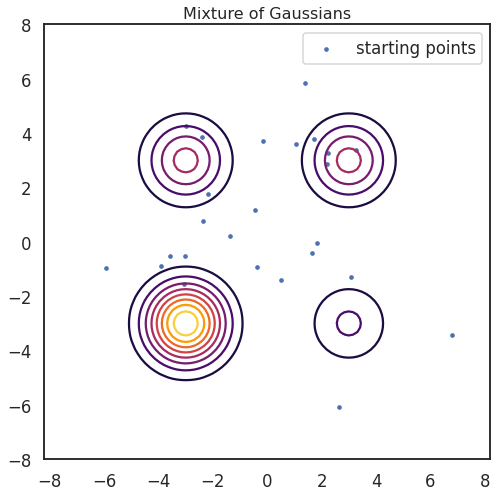

In [30]:
dim = 10
locs = torch.FloatTensor([[0]*(dim-2) + [-3,3], [0]*(dim-2) + [-3,-3], [0]*(dim-2)+[3,3], [0]*(dim-2)+[3,-3]])
covs = torch.eye(dim)[None, ...].repeat(4, 1, 1).float()
weights = torch.FloatTensor([1, 2, 1, 0.5])

mog = MoG(locs, covs, weights)

plt.figure(figsize = (8,8))
ax = plt.subplot()
mog.plot_2d_countour(ax)


start_mog = 3*torch.randn((N_CHAINS, mog.dim))
proj_slice = [PROJ_DIM1, PROJ_DIM2]
plt.scatter(*start_mog[:, proj_slice].T, s=10, label='starting points')
plt.title('Mixture of Gaussians', fontsize = 16)
plt.axis('equal')
plt.legend()
plt.show()


$f(x_1, x_2, \cdots, x_d) = \left[\prod\limits_{i=1}^{d-1} \mathcal{N}(x_i \mid 0, e^{x_d / 2}) \right] \times \mathcal{N}(x_d \mid 0, a)$

“Slice sampling”. R. Neal, Annals of statistics, 705 (2003) https://doi.org/10.1214/aos/1056562461

Next example: $d$-dimensional Funnel distribution. Note that it allows for the reparametrisation, that allows for exact sampling. The  corresponding density function:
$$
p_{f}(x) = \operatorname{Z}^{-1} \exp\left(- x_d^2/2a^2 - (1/2) e^{-x_d} \sum\nolimits_{i=1}^{d-1}\{x_i^2 + x_1\}\right)\,, \quad d \geq 2,
$$
Note that we have a doule exponent in the density...

In [42]:
class Funnel(object):
    """
    Funnel distribution.

    “Slice sampling”. R. Neal, Annals of statistics, 705 (2003) https://doi.org/10.1214/aos/1056562461

    Args:
        dim - dimension
        nu - parameter
    """
    def __init__(self, dim: int, a: float=3):
        self._dim = dim
        self.a = a
        self.normal_last = Normal(0, a)

    @property
    def dim(self) -> int:
        return self._dim
    
    def log_prob(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """
        Returns:
            log p(x)
        """
        normal_first = Normal(torch.zeros(x.shape[:-1]), torch.exp(x[..., -1] / 2.))
        return normal_first.log_prob(x[..., :-1].permute(-1, *range(x.ndim-1))).sum(0) + \
            self.normal_last.log_prob(x[..., -1])

    def plot_2d_countour(self, ax):
        x = np.linspace(-10, 10, 100)
        y = np.linspace(-7, 7, 100)
        X, Y = np.meshgrid(x, y)
        inp = torch.from_numpy(np.stack([X, Y], -1))
        Z = self.log_prob(inp.reshape(-1, 2)).reshape(inp.shape[:-1])

        #levels = np.quantile(Z, np.linspace(0.9, 0.99, 5))

        ax.contour(X, Y, Z.exp(), 
                   #levels = levels,
                   levels=7, 
                   alpha=1., cmap='inferno')


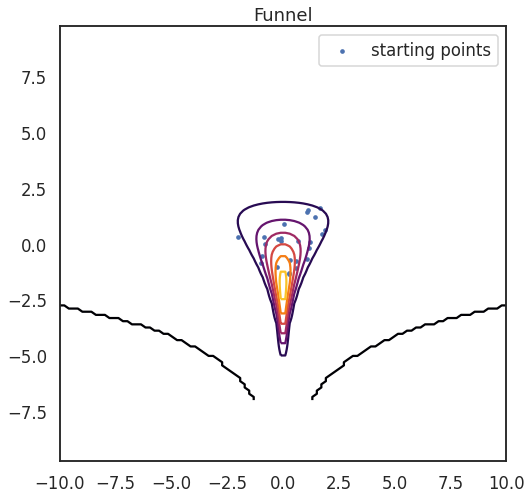

In [45]:
#default parameter
funnel_a = 2
dim = 10

funnel = Funnel(dim, funnel_a)
plt.figure(figsize = (8,8))
ax = plt.subplot()
funnel.plot_2d_countour(ax)

start_funnel = torch.randn((N_CHAINS, funnel.dim))
proj_slice = [PROJ_DIM1, PROJ_DIM2]
plt.scatter(*start_funnel[:, proj_slice].T, s=10, label='starting points')
plt.title('Funnel')
plt.legend()
plt.axis('equal')
plt.show()

Next potential - Banana-shape distribution. It has somehow simpler geometry, compared to the Funnel. The density function:
$$
p_{b}(x) = Z^{-1} \exp\left(- \sum\nolimits_{i=1}^{d/2}\bigl\{x_{2i}^2/2a^2 - (x_{2i-1} - bx_{2i}^{2} + a^2 b)^{2}/2 \bigr\}\right)\,, \quad d = 2k, k \in \mathbb{N}
$$

In [60]:
class Banana(object):
    """
    """
    def __init__(self, dim: int, b: float, sigma: float):
        #self.q = q
        self.b = b
        self.sigma = sigma
        self._dim = dim
        #self.normal_even = Normal(1, 1)
        #self.normal_odd = Normal(0, q)

    @property
    def dim(self) -> int:
        return self._dim
    
    def log_prob(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """
        Returns:
            log p(x)
        """
        even = np.arange(0, x.shape[-1], 2)
        odd = np.arange(1, x.shape[-1], 2)
        ll = -0.5*(x[..., odd] - self.b*x[..., even]**2 + (self.sigma**2)*self.b)**2 - ((x[..., even])**2)/(2*self.sigma**2)
        return ll.sum(-1)

        #return self.normal_even.log_prob(x[..., even]).sum(-1) + \
        #    self.normal_odd.log_prob(x[..., even] - x[..., odd] ** 2).sum(-1)

    def plot_2d_countour(self, ax):
        x = np.linspace(-10, 10, 100)
        y = np.linspace(-3, 3, 100)
        X, Y = np.meshgrid(x, y)
        inp = torch.from_numpy(np.stack([X, Y], -1))
        Z = self.log_prob(inp.reshape(-1, 2)).reshape(inp.shape[:-1])
        #levels = np.quantile(Z, np.linspace(0.9, 0.99, 5))

        ax.contour(X, Y, Z.exp(), 
                   #levels = levels,
                   levels=5,
                   alpha=1., cmap='inferno')
        

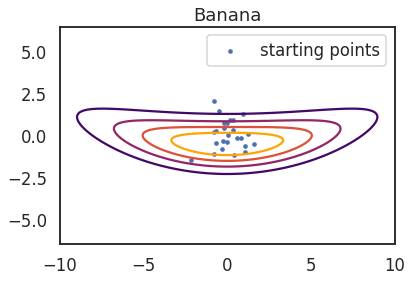

In [62]:
sigma_b = 5.0
banana_b = 0.02

banana = Banana(50, banana_b, sigma_b)
ax = plt.subplot()
banana.plot_2d_countour(ax)

start_banana = torch.randn((N_CHAINS, banana.dim))
proj_slice = [PROJ_DIM1, PROJ_DIM2]
plt.scatter(*start_banana[:, proj_slice].T, s=10, label='starting points')
plt.title('Banana')
plt.legend()
plt.axis('equal')
plt.show()

Let us check how the rejection sampling works

As we can observe, the performane of rejection sampling degrades quickly with dimension $d$. Hence, we try another story (i-SIR)

In [ ]:
def ISIR(start: torch.FloatTensor, 
        target,
        proposal, 
        n_samples: int,
        burn_in: int, 
        *, 
        n_particles: int, 
        verbose: bool=False) -> Tuple[List[torch.FloatTensor], List]:
    """
    Iterated Sampling Importance Resampling

    Args:
        start - strating points of shape [n_chains x dim]
        target - target distribution instance with method "log_prob"
        proposal - proposal distribution instance with methods "log_prob" and "sample"
        n_samples - number of last samples from each chain to return
        burn_in - number of first samples from each chain to throw away
        n_particles - number of particles including one from previous step
        verbose - whether to show iterations' bar

    Returns:
        tensor of chains with shape [n_samples, n_chains, dim], acceptance rates for each iteration
    """
    chains = []
    acceptance_rate = []
    
    x = start.clone()
    logp_x = target.log_prob(x)
    logq_x = proposal.log_prob(x)

    range_ = trange if verbose else range
    for step_id in range_(n_samples + burn_in):
        particles = proposal.sample((x.shape[0], n_particles - 1))
        logqs = torch.cat([logq_x[:, None], proposal.log_prob(particles)], 1)
        logps = torch.cat([logp_x[:, None], target.log_prob(particles)], 1)
        particles = torch.cat([x[:, None, :], particles], 1)

        log_weights = logps - logqs
        indices = Categorical(logits=log_weights).sample()
        
        x = particles[np.arange(x.shape[0]), indices]
        logp_x = logps[np.arange(x.shape[0]), indices]
        logq_x = logqs[np.arange(x.shape[0]), indices]

        acceptance_rate.append((indices != 0).float().mean().item())
        if step_id >= burn_in:
            chains.append(x.detach().data.clone())
    chains = torch.stack(chains, 0)        
    return chains, acceptance_rate

In [ ]:
class CauchyMixture(object):
    def __init__(self, 
            loc: torch.FloatTensor, 
            cov: torch.FloatTensor,
    ):
        self.loc = loc
        self.cov = cov
        self._dim = loc.shape[-1]
        self.cauchy = Cauchy(loc=self.loc, scale=self.cov)
        self.cauchy_minus = Cauchy(loc=-self.loc, scale=self.cov)

    @property
    def dim(self):
      return self._dim

    def log_prob(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """
        Returns:
            log p(x)
        """
        concat = torch.cat(
            [
                self.cauchy.log_prob(x)[None, ...],
                self.cauchy_minus.log_prob(x)[None, ...],
            ],
            0,
        )
        return torch.logsumexp(concat, 0).sum(-1)

    def plot_2d_countour(self, ax):
        x = np.linspace(-5, 5, 100)
        y = np.linspace(-5, 5, 100)
        X, Y = np.meshgrid(x, y)
        inp = torch.from_numpy(np.stack([X, Y], -1))

        cauchy = Cauchy(loc=self.loc[[PROJ_DIM1, PROJ_DIM2]], scale=self.cov[[PROJ_DIM1, PROJ_DIM2]])
        cauchy_minus = Cauchy(loc=-self.loc[[PROJ_DIM1, PROJ_DIM2]], scale=self.cov[[PROJ_DIM1, PROJ_DIM2]])

        catted = torch.cat(
            [
                cauchy.log_prob(inp.reshape(-1, 2))[None, ...],
                cauchy_minus.log_prob(inp.reshape(-1, 2))[None, ...],
            ],
            0,
        )
        Z = torch.logsumexp(catted, 0).sum(-1).reshape(inp.shape[:-1])
        #levels = np.quantile(Z, np.linspace(0.9, 0.99, 5))

        ax.contour(X, Y, Z.exp(), 
                   #levels = levels,
                   levels=4, 
                   alpha=1., cmap='inferno')


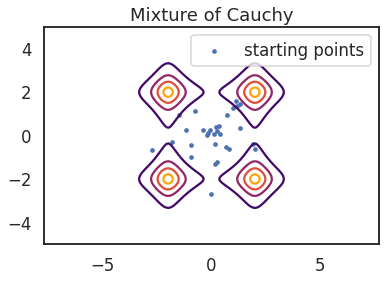

In [ ]:
dim = 30
loc = 2 * torch.ones(dim)
cov = 0.7 * torch.ones(dim)

moc = CauchyMixture(loc, cov)
ax = plt.subplot()
moc.plot_2d_countour(ax)

start_moc = torch.randn((N_CHAINS, moc.dim))
proj_slice = [PROJ_DIM1, PROJ_DIM2]
plt.scatter(*start_moc[:, proj_slice].T, s=10, label='starting points')
plt.title('Mixture of Cauchy')
plt.legend()
plt.axis('equal')
plt.show()

In [ ]:
# some code for drawing

def ema(series: Iterable, n: int) -> List:
    """
    returns an n period exponential moving average for
    the time series
    """
    series = np.array(series)
    ema = []
    j = 1

    #get n sma first and calculate the next n period ema
    sma = sum(series[:n]) / n
    multiplier = 2 / float(1 + n)
    ema.append(sma)

    #EMA(current) = ( (Price(current) - EMA(prev) ) x Multiplier) + EMA(prev)
    ema.append(( (series[n] - sma) * multiplier) + sma)

    #now calculate the rest of the values
    for i in series[n+1:]:
        tmp = ( (i - ema[j]) * multiplier) + ema[j]
        j = j + 1
        ema.append(tmp)

    return ema

def plot_result(chains, dist, chain_id=0):
    proj_slice = [PROJ_DIM1, PROJ_DIM2]
    proj_dim1 = dist.dim + PROJ_DIM1 + 1 if PROJ_DIM1 < 0 else PROJ_DIM1 + 1
    proj_dim2 = dist.dim + PROJ_DIM2 + 1 if PROJ_DIM2 < 0 else PROJ_DIM2 + 1

    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    result = chains.reshape(-1, chains.shape[-1])
    dist.plot_2d_countour(axs[0])
    xmin, xmax = axs[0].get_xlim()
    ymin, ymax = axs[0].get_ylim()

    axs[0].scatter(*result[:, proj_slice].T, alpha=min(0.6, 1000./result.shape[0]), s=10)
    axs[0].set_title(f'Projected samples from {N_CHAINS} chains')

    kernel = gaussian_kde(result[:, proj_slice].T)
    x = np.linspace(xmin, xmax, 100)
    y = np.linspace(ymin, ymax, 100)
    X, Y = np.meshgrid(x, y)
    positions = np.vstack([X.ravel(), Y.ravel()])
    kde = np.reshape(kernel(positions).T, X.shape)
    axs[1].contour(X, Y, kde, cmap='inferno')
    axs[1].set_title(f'KDE')

    chain_id = 0
    result = chains[:, chain_id]
    dist.plot_2d_countour(axs[2])
    axs[2].plot(*result[:, proj_slice].T, alpha=min(0.6, 1000./result.shape[0]))
    axs[2].set_title(f'Trajectory of chain {chain_id}')

    if len(np.unique(result[:, proj_slice], axis=0)) > 0:
      try:
        kernel = gaussian_kde(np.unique(result[:, proj_slice], axis=0).T)
        x = np.linspace(xmin, xmax, 100)
        y = np.linspace(ymin, ymax, 100)
        X, Y = np.meshgrid(x, y)
        positions = np.vstack([X.ravel(), Y.ravel()])
        kde = np.reshape(kernel(positions).T, X.shape)
        axs[3].contour(X, Y, kde, cmap='inferno')
        axs[3].set_title(f'KDE')
      except numpy.linalg.LinAlgError:
        pass


    for ax in axs:
      ax.set_xlim(xmin, xmax)
      ax.set_ylim(ymin, ymax)
      ax.set_xlabel(fr'$X{proj_dim1}$')
      ax.set_ylabel(fr'$X{proj_dim2}$')
      # ax.axis('square')

    fig.tight_layout()
    plt.show()

In [ ]:
def RWM(start: torch.FloatTensor, 
        target,
        proposal, 
        n_samples: int,
        burn_in: int,
        *, 
        verbose: bool=False) -> Tuple[torch.FloatTensor, List]:
    """
    Random Walk Metropolis

    Args:
        start - strating points of shape [n_chains, dim]
        target - target distribution instance with method "log_prob"
        proposal - proposal distribution instance with method "sample"
        n_samples - number of last samples from each chain to return
        burn_in - number of first samples from each chain to throw away
        verbose - whether to show iterations' bar

    Returns:
        tensor of chains with shape [n_samples, n_chains, dim], acceptance rates for each iteration
    """
    chains = []
    acceptance_rate = []
    x = start.clone()
    x.requires_grad_(True)
    x.grad = None
    logp_x = target.log_prob(x)
    
    range_ = trange if verbose else range
    for step_id in range_(n_samples + burn_in):
        log_prob = target.log_prob(x)
        y = x + proposal.sample(x.shape[:-1])
        logp_y = target.log_prob(y)

        accept_prob = torch.clamp((logp_y - logp_x).exp(), max=1)
        mask = torch.rand_like(accept_prob) < accept_prob
        with torch.no_grad():
            x[mask, :] = y[mask, :]
            logp_x[mask] = logp_y[mask]

        acceptance_rate.append(mask.float().mean().item())
        if step_id >= burn_in:
            chains.append(x.detach().data.clone())
    chains = torch.stack(chains, 0)
    return chains, acceptance_rate

In [ ]:
proposal_scale = 0.1
proposal = MNormal(torch.zeros(mog.dim), torch.eye(mog.dim) * proposal_scale**2)

chains, acceptance_rates = RWM(start_mog, mog, proposal, N_SAMPLES, BURN_IN, verbose=True)

100%|██████████| 1100/1100 [00:02<00:00, 434.49it/s]


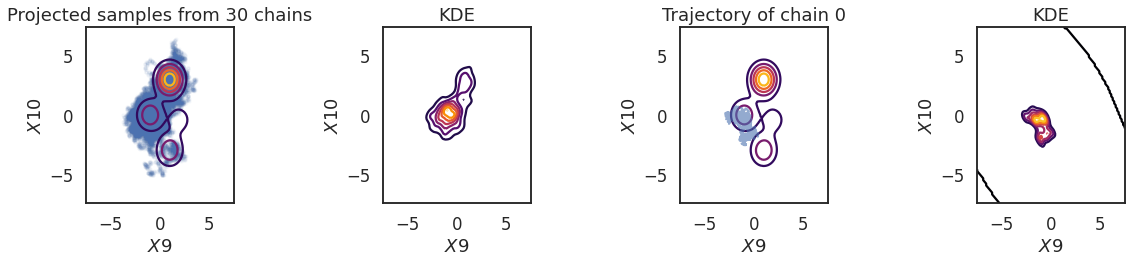

In [ ]:
plot_result(chains, mog)

In [ ]:
def ULA(start: torch.FloatTensor, 
        target, 
        n_samples: int,
        burn_in: int,
        *, 
        step_size: float, 
        verbose: bool=False) -> torch.FloatTensor:
    """
    Unadjusted Langevin Algorithm

    Args:
        start - strating points of shape [n_chains, dim]
        target - target distribution instance with method "log_prob"
        n_samples - number of last samples from each chain to return
        burn_in - number of first samples from each chain to throw away
        step_size - step size for drift term
        verbose - whether to show iterations' bar

    Returns:
        tensor of chains with shape [n_samples, n_chains, dim]
    """
    chains = []
    x = start.clone()
    x.requires_grad_(True)
    x.grad = None
    
    range_ = trange if verbose else range
    for step_id in range_(n_samples + burn_in):
        log_prob = target.log_prob(x)
        grad = torch.autograd.grad(log_prob.sum(), x)[0]
        x = x + step_size * grad + (2 * step_size) ** .5 * torch.randn_like(x)
        
        if step_id >= burn_in:
            chains.append(x.detach().data.clone())
    chains = torch.stack(chains, 0)
    return chains


In [ ]:
step_size = 0.05
chains = ULA(start_mog, mog, N_SAMPLES, BURN_IN, step_size=step_size, verbose=True)

100%|██████████| 1100/1100 [00:01<00:00, 580.52it/s]


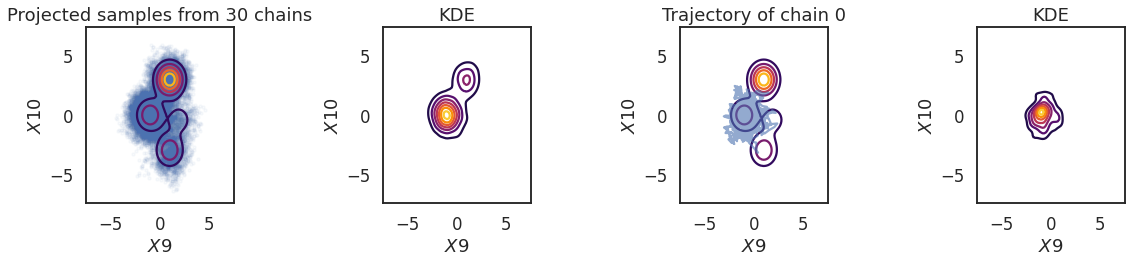

In [ ]:
plot_result(chains, mog)

In [ ]:
step_size = 0.002
chains = ULA(start_banana, banana, N_SAMPLES, BURN_IN, step_size=step_size, verbose=True)

100%|██████████| 1100/1100 [00:00<00:00, 1435.72it/s]


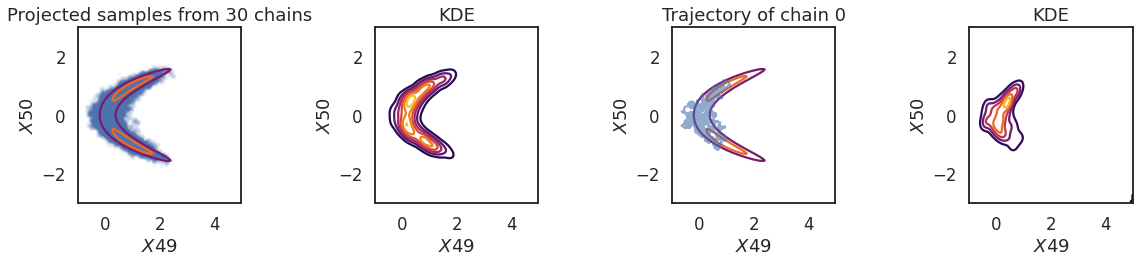

In [ ]:
plot_result(chains, banana)

In [ ]:
step_size = 0.01
chains = ULA(start_funnel, funnel, N_SAMPLES, BURN_IN, step_size=step_size, verbose=True)

100%|██████████| 1100/1100 [00:00<00:00, 1395.35it/s]


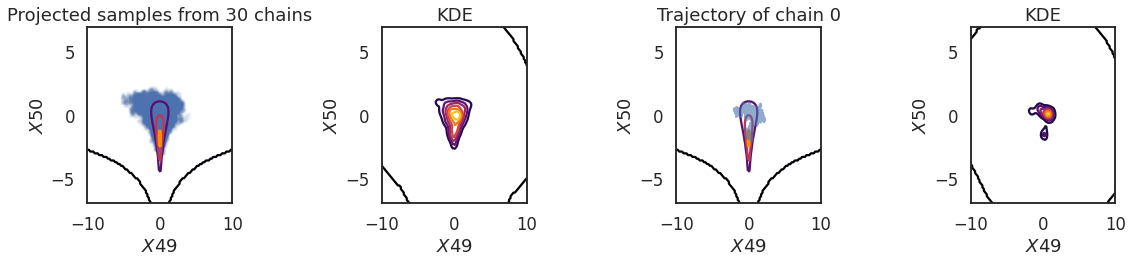

In [ ]:
plot_result(chains, funnel)

In [ ]:
step_size = 0.01
chains = ULA(start_moc, moc, N_SAMPLES, BURN_IN, step_size=step_size, verbose=True)

100%|██████████| 1100/1100 [00:00<00:00, 1831.23it/s]


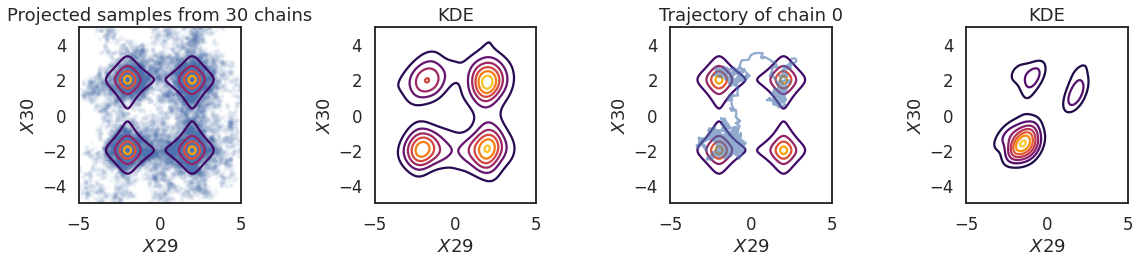

In [ ]:
plot_result(chains, moc)

In [ ]:
def MALA(start: torch.FloatTensor, 
        target, 
        n_samples: int,
        burn_in: int,
        *, 
        step_size: float, 
        verbose: bool=False) -> Tuple[torch.FloatTensor, List]:
    """
    Metropolis-Adjusted Langevin Algorithm with Normal proposal

    Args:
        start - strating points of shape [n_chains, dim]
        target - target distribution instance with method "log_prob"
        n_samples - number of last samples from each chain to return
        burn_in - number of first samples from each chain to throw away
        step_size - step size for drift term
        verbose - whether to show iterations' bar

    Returns:
        tensor of chains with shape [n_samples, n_chains, dim], acceptance rates for each iteration
    """
    std_normal = MNormal(torch.zeros(start.shape[-1]), torch.eye(start.shape[-1]))
    chains = []
    acceptance_rate = []
    
    x = start.clone()
    x.requires_grad_(True)
    x.grad = None
    logp_x = target.log_prob(x)
    grad_x = torch.autograd.grad(logp_x.sum(), x)[0]

    range_ = trange if verbose else range
    for step_id in range_(n_samples + burn_in):
        noise =  torch.randn_like(x)
        y = x + step_size * grad_x + noise * (2 * step_size) ** .5

        logp_y = target.log_prob(y)
        grad_y = torch.autograd.grad(logp_y.sum(), y)[0]

        log_qyx = std_normal.log_prob(noise)
        log_qxy = std_normal.log_prob((x - y - step_size * grad_y) / (2 * step_size) ** .5)
        
        accept_prob = torch.clamp((logp_y + log_qxy - logp_x - log_qyx).exp(), max=1)
        mask = torch.rand_like(accept_prob) < accept_prob

        with torch.no_grad():
            x[mask, :] = y[mask, :]
            logp_x[mask] = logp_y[mask]
            grad_x[mask] = grad_y[mask]

        acceptance_rate.append(mask.float().mean().item())
        if step_id >= burn_in:
            chains.append(x.detach().data.clone())
    chains = torch.stack(chains, 0)
    return chains, acceptance_rate


In [ ]:
step_size = 0.05 #2.5
chains, acceptance_rates = MALA(start_mog, mog, N_SAMPLES, BURN_IN, step_size=step_size, verbose=True)

100%|██████████| 1100/1100 [00:02<00:00, 467.06it/s]


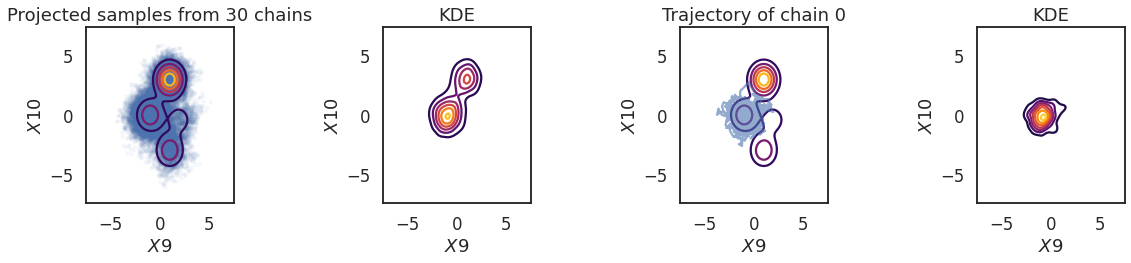

In [ ]:
plot_result(chains, mog)

In [ ]:
step_size = 0.005
chains, acceptance_rates = MALA(start_banana, banana, N_SAMPLES, BURN_IN, step_size=step_size, verbose=True)

100%|██████████| 1100/1100 [00:01<00:00, 772.73it/s]


Text(0.5, 0, 'Iteration')

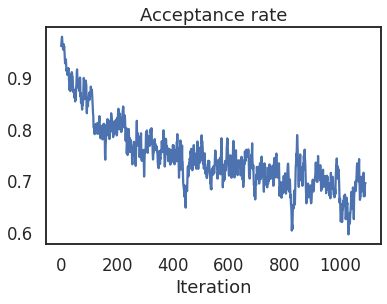

In [ ]:
plt.plot(ema(acceptance_rates, 10))
plt.title('Acceptance rate')
plt.xlabel('Iteration')

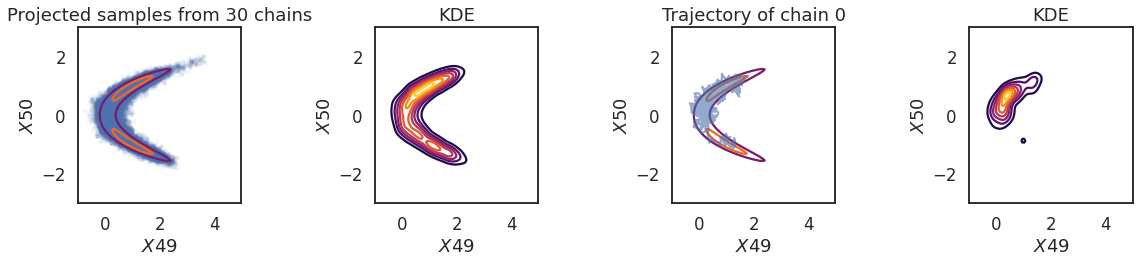

In [ ]:
plot_result(chains, banana)

In [ ]:
step_size = 0.03
chains, acceptance_rates = MALA(start_funnel, funnel, N_SAMPLES, BURN_IN, step_size=step_size, verbose=True)

100%|██████████| 1100/1100 [00:01<00:00, 718.19it/s]


Text(0.5, 0, 'Iteration')

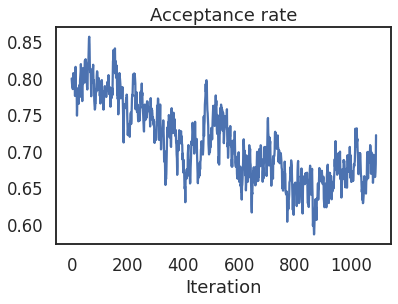

In [ ]:
plt.plot(ema(acceptance_rates, 10))
plt.title('Acceptance rate')
plt.xlabel('Iteration')

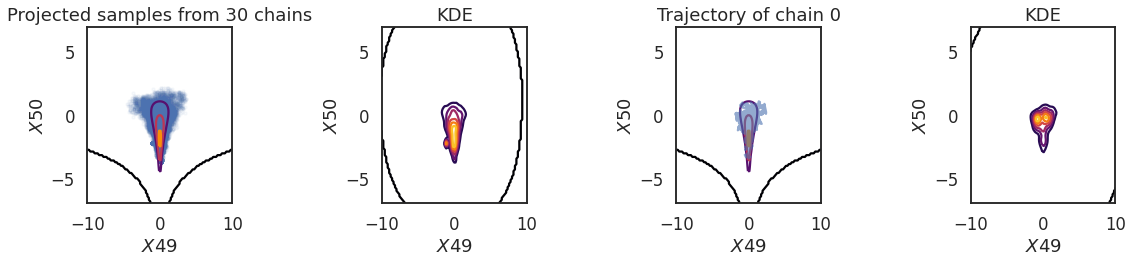

In [ ]:
plot_result(chains, funnel)

In [ ]:
step_size = 0.01
chains, acceptance_rates = MALA(start_moc, moc, N_SAMPLES, BURN_IN, step_size=step_size, verbose=True)

100%|██████████| 1100/1100 [00:01<00:00, 806.28it/s]


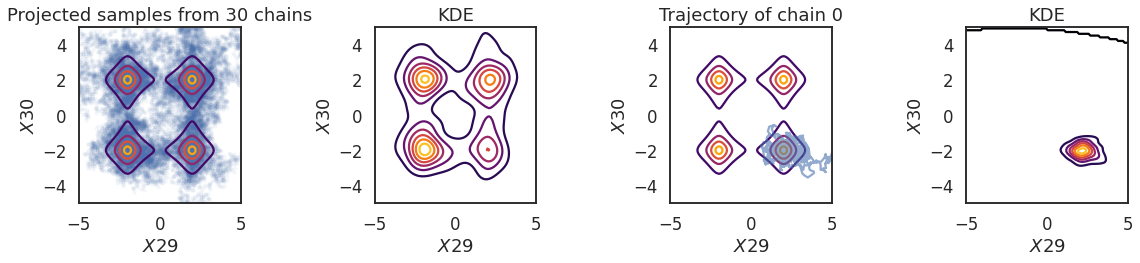

In [ ]:
plot_result(chains, moc)

In [ ]:
proposal_scale = 1.5
n_particles = 20
proposal = MNormal(torch.zeros(mog.dim), torch.eye(mog.dim) * proposal_scale**2)

chains, acceptance_rates = ISIR(start_mog, mog, proposal, N_SAMPLES, BURN_IN, n_particles=n_particles, verbose=True)

100%|██████████| 1100/1100 [00:01<00:00, 583.32it/s]


Text(0.5, 0, 'Iteration')

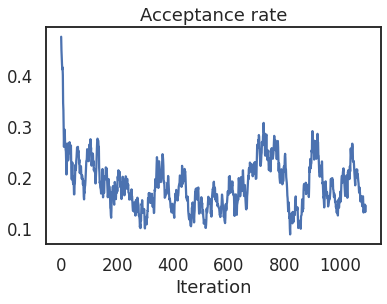

In [ ]:
plt.plot(ema(acceptance_rates, 10))
plt.title('Acceptance rate')
plt.xlabel('Iteration')
# plt.xscale('log')

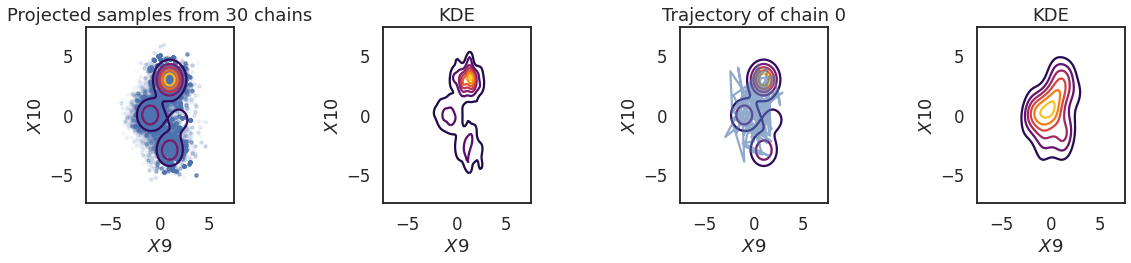

In [ ]:
plot_result(chains, mog)

In [ ]:
proposal_scale = 0.25 #1.0
n_particles = 20
proposal = MNormal(torch.zeros(banana.dim), torch.eye(banana.dim) * proposal_scale**2)

chains, acceptance_rates = ISIR(start_banana, banana, proposal, N_SAMPLES, BURN_IN, n_particles=n_particles, verbose=True)

100%|██████████| 1100/1100 [00:01<00:00, 559.88it/s]


Text(0.5, 0, 'Iteration')

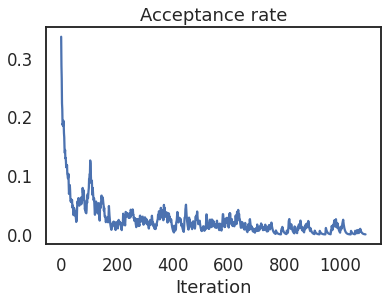

In [ ]:
plt.plot(ema(acceptance_rates, 10))
plt.title('Acceptance rate')
plt.xlabel('Iteration')

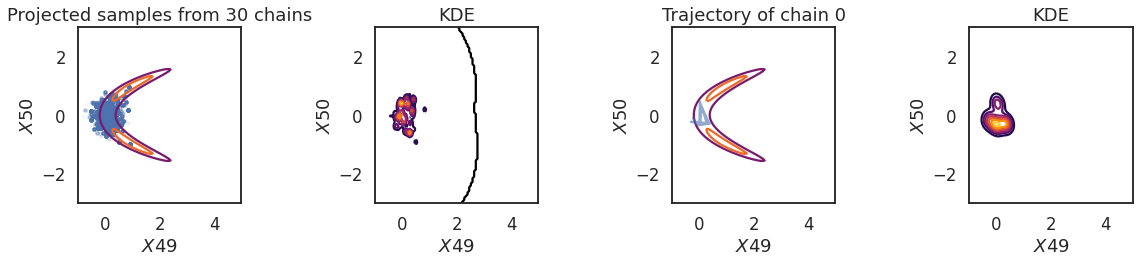

In [ ]:
plot_result(chains, banana)

In [ ]:
proposal_scale = 1.0
n_particles = 20
proposal = MNormal(torch.zeros(funnel.dim), torch.eye(funnel.dim) * proposal_scale**2)

chains, acceptance_rates = ISIR(start_funnel, funnel, proposal, N_SAMPLES, BURN_IN, n_particles=n_particles, verbose=True)

100%|██████████| 1100/1100 [00:01<00:00, 601.02it/s]


Text(0.5, 0, 'Iteration')

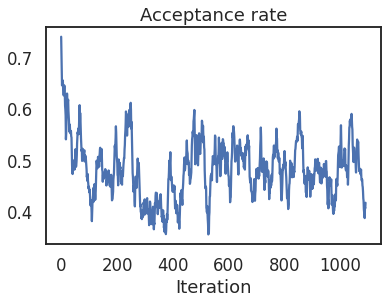

In [ ]:
plt.plot(ema(acceptance_rates, 10))
plt.title('Acceptance rate')
plt.xlabel('Iteration')

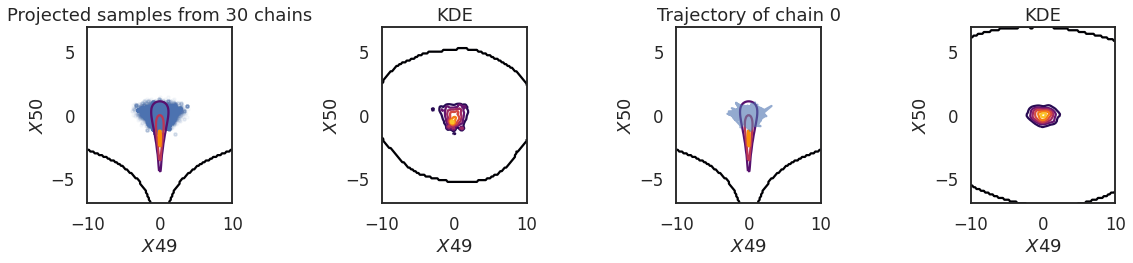

In [ ]:
plot_result(chains, funnel)

In [ ]:
proposal_scale = 1.0
n_particles = 20
proposal = MNormal(torch.zeros(moc.dim), torch.eye(moc.dim) * proposal_scale**2)

chains, acceptance_rates = ISIR(start_moc, moc, proposal, N_SAMPLES, BURN_IN, n_particles=n_particles, verbose=True)

100%|██████████| 1100/1100 [00:02<00:00, 419.59it/s]


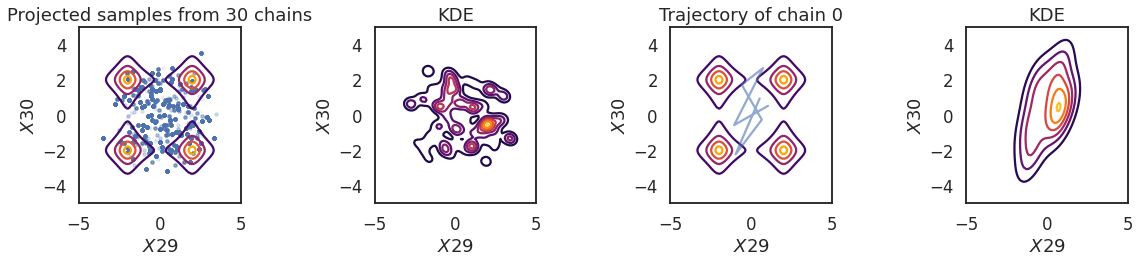

In [ ]:
plot_result(chains, moc)

In [ ]:
def Ex2MCMC(start: torch.FloatTensor, 
        target,
        proposal,
        n_samples: int,
        burn_in: int,
        *, 
        step_size: float,
        n_particles: int, 
        n_mala_steps: int = 1,
        verbose: bool=False) -> Tuple[List[torch.FloatTensor], List]:
    """
    Ex2MCMC

    Args:
        start - strating points of shape [n_chains x dim]
        target - target distribution instance with method "log_prob"
        proposal - proposal distribution instance with methods "log_prob" and "sample"
        n_samples - number of last samples from each chain to return
        burn_in - number of first samples from each chain to throw away
        step_size - step size for drift term
        n_particles - number of particles including one from previous step
        n_mala_steps - number of MALA steps after each SIR step
        verbose - whether to show iterations' bar

    Returns:
        tensor of chains with shape [n_samples, n_chains, dim], acceptance rates for each iteration
    """
    chains = []
    acceptance_rate = []
    
    x = start.clone()
    x.requires_grad_(True)
    x.grad = None
    logp_x = target.log_prob(x)
    logq_x = proposal.log_prob(x)

    range_ = trange if verbose else range
    for step_id in range_(n_samples + burn_in):
        particles = proposal.sample((x.shape[0], n_particles - 1))
        log_qs = torch.cat([logq_x[:, None], proposal.log_prob(particles)], 1)
        log_ps = torch.cat([logp_x[:, None], target.log_prob(particles)], 1)
        particles = torch.cat([x[:, None, :], particles], 1)

        log_weights = log_ps - log_qs
        indices = Categorical(logits=log_weights).sample()
        x = particles[np.arange(x.shape[0]), indices]

        if n_mala_steps > 0:
            xs, acc = MALA(x, target, n_mala_steps, 0, step_size=step_size)
            x = xs[-1]
            logp_x = target.log_prob(x)
            logq_x = proposal.log_prob(x)
        else:
            logp_x = log_ps[np.arange(x.shape[0]), indices]
            logq_x = log_qs[np.arange(x.shape[0]), indices]

        acceptance_rate.append((indices != 0).float().mean().item())
        if step_id >= burn_in:
            chains.append(x.detach().data.clone())
    chains = torch.stack(chains, 0)
    return chains, acceptance_rate

In [ ]:
step_size = 0.05
proposal_scale = 1.0
n_particles = 10
n_mala_steps = 1
proposal = MNormal(torch.zeros(mog.dim), torch.eye(mog.dim) * proposal_scale**2)

chains, acceptance_rates = Ex2MCMC(start_mog, mog, proposal, N_SAMPLES, BURN_IN, 
    step_size=step_size, n_particles=n_particles, n_mala_steps=n_mala_steps, verbose=True)

100%|██████████| 1100/1100 [00:07<00:00, 150.32it/s]


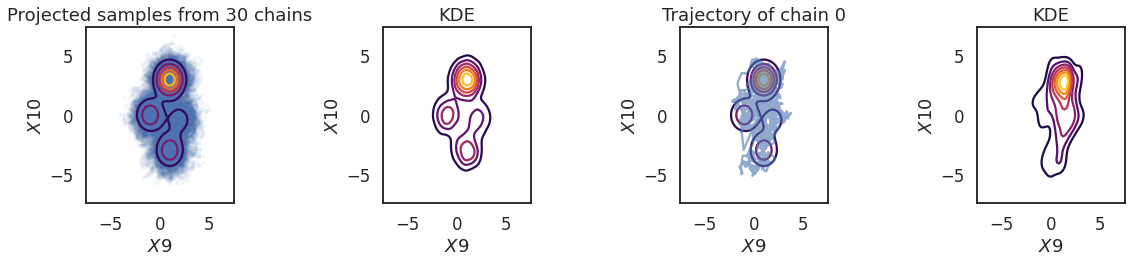

In [ ]:
plot_result(chains, mog)

In [ ]:
step_size = 0.005
proposal_scale = 0.25
n_particles = 20
n_mala_steps = 1
proposal = MNormal(torch.zeros(banana.dim), torch.eye(banana.dim) * proposal_scale**2)

chains, acceptance_rates = Ex2MCMC(start_banana, banana, proposal, N_SAMPLES, BURN_IN, 
    step_size=step_size, n_particles=n_particles, n_mala_steps=n_mala_steps, verbose=True)

100%|██████████| 1100/1100 [00:05<00:00, 217.76it/s]


Text(0.5, 0, 'Iteration')

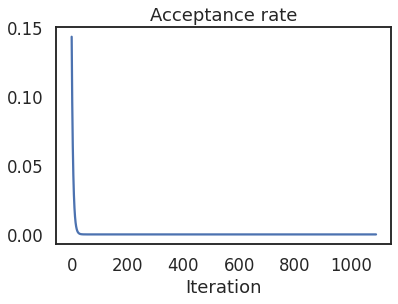

In [ ]:
plt.plot(ema(acceptance_rates, 10))
plt.title('Acceptance rate')
plt.xlabel('Iteration')
# ???

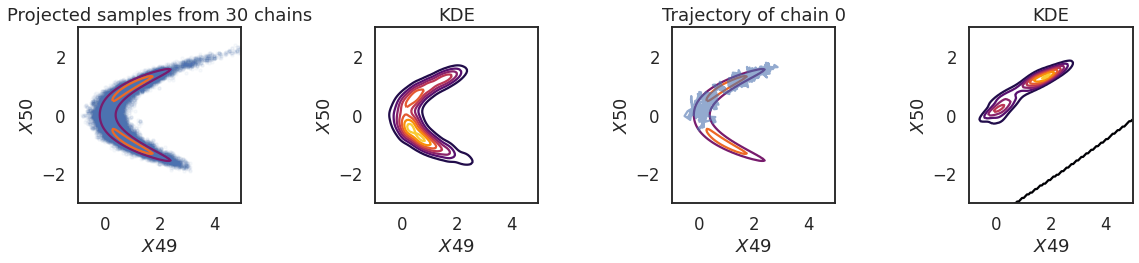

In [ ]:
plot_result(chains, banana)

In [ ]:
step_size = 0.1
proposal_scale = 1
n_particles = 20
n_mala_steps = 1
proposal = MNormal(torch.zeros(funnel.dim), torch.eye(funnel.dim) * proposal_scale**2)

chains, acceptance_rates = Ex2MCMC(start_funnel, funnel, proposal, N_SAMPLES, BURN_IN, 
    step_size=step_size, n_particles=n_particles, n_mala_steps=n_mala_steps, verbose=True)

100%|██████████| 1100/1100 [00:05<00:00, 196.55it/s]


Text(0.5, 0, 'Iteration')

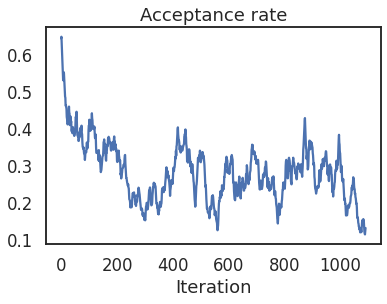

In [ ]:
plt.plot(ema(acceptance_rates, 10))
plt.title('Acceptance rate')
plt.xlabel('Iteration')
# plt.xscale('log')

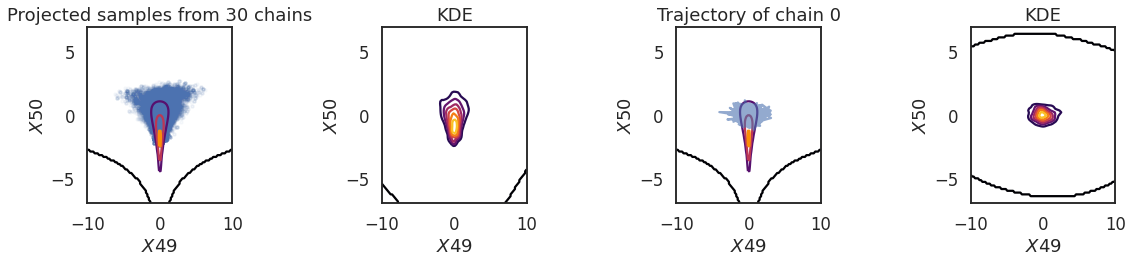

In [ ]:
plot_result(chains, funnel)

In [ ]:
step_size = 0.1
proposal_scale = 1
n_particles = 20
n_mala_steps = 1
proposal = MNormal(torch.zeros(moc.dim), torch.eye(moc.dim) * proposal_scale**2)

chains, acceptance_rates = Ex2MCMC(start_moc, moc, proposal, N_SAMPLES, BURN_IN, 
    step_size=step_size, n_particles=n_particles, n_mala_steps=n_mala_steps, verbose=True)

100%|██████████| 1100/1100 [00:04<00:00, 243.78it/s]


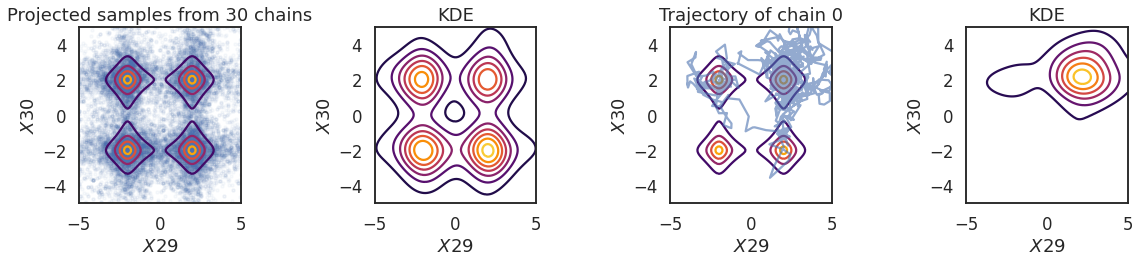

In [ ]:
plot_result(chains, moc)

In [ ]:
def HMC(start,
        target, 
        n_samples: int,
        burn_in: int, 
        *, 
        step_size: float,
        n_leap_steps: int,
        verbose: bool = False) -> torch.FloatTensor:
    """
    Hamiltonian Monte Carlo

    Args:
        start - strating points of shape [n_chains x dim]
        target - target distribution instance with method "log_prob"
        n_samples - number of last samples from each chain to return
        burn_in - number of first samples from each chain to throw away
        step_size - step size for drift term
        n_leap_steps - number of leapfrog steps
        verbose - whether to show iterations' bar

    Returns:
        tensor of chains with shape [n_samples, n_chains, dim], acceptance rates for each iteration
    """

    x = start.clone()
    x.requires_grad_(False)
    def energy(z):
        z = z["points"]
        return -target.log_prob(z).sum()

    kernel = pyro_hmc(
        potential_fn=energy, step_size=step_size, num_steps=n_leap_steps, full_mass=False
        )

    init_params = {"points": x}
    mcmc_true = MCMC(
        kernel=kernel,
        num_samples=n_samples,
        initial_params=init_params,
        warmup_steps=burn_in,
    )
    mcmc_true.run()

    q_true = mcmc_true.get_samples(group_by_chain=True)["points"]
    samples_true = q_true.view(-1, *start.shape)

    return samples_true

In [ ]:
step_size = 0.1
n_leap_steps = 5

chains = HMC(start_mog, mog, N_SAMPLES, BURN_IN,
    step_size=step_size, n_leap_steps=n_leap_steps, verbose=True)

Sample: 100%|██████████| 1100/1100 [00:03, 301.38it/s, step size=4.22e-01, acc. prob=0.890]


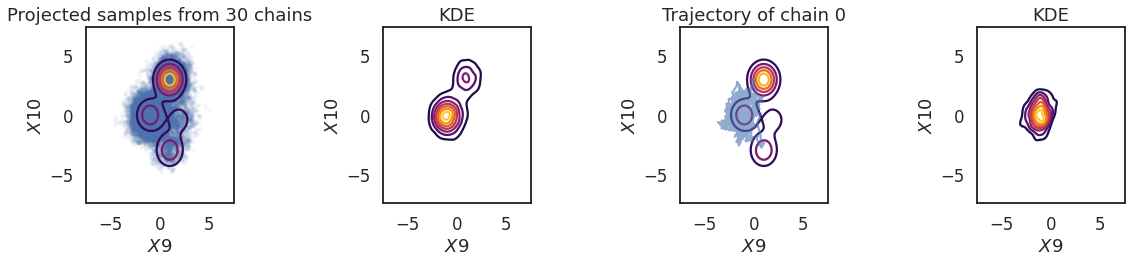

In [ ]:
plot_result(chains, mog)

In [ ]:
step_size = 0.1
n_leap_steps = 5

chains = HMC(start_banana, banana, N_SAMPLES, BURN_IN,
    step_size=step_size, n_leap_steps=n_leap_steps, verbose=True)

Sample: 100%|██████████| 1100/1100 [00:09, 111.24it/s, step size=4.10e-02, acc. prob=0.892]


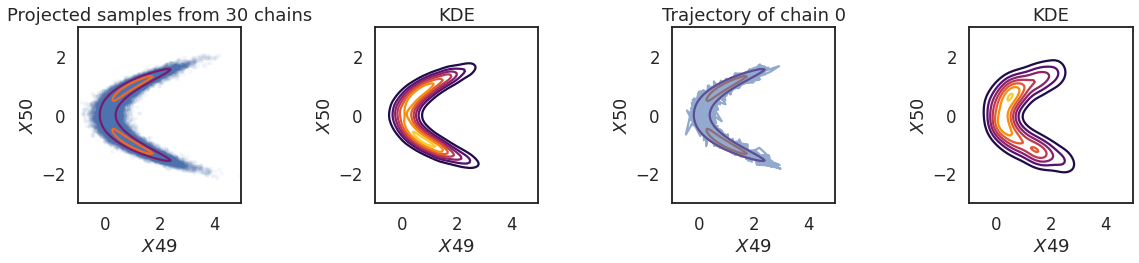

In [ ]:
plot_result(chains, banana)

In [ ]:
step_size = 0.1
n_leap_steps = 5

chains = HMC(start_funnel, funnel, N_SAMPLES, BURN_IN,
    step_size=step_size, n_leap_steps=n_leap_steps, verbose=True)

Sample: 100%|██████████| 1100/1100 [00:06, 168.96it/s, step size=1.06e-01, acc. prob=0.732]


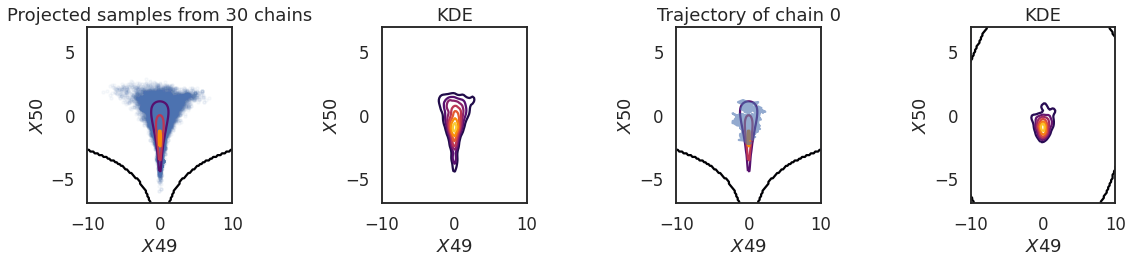

In [ ]:
plot_result(chains, funnel)

In [ ]:
step_size = 0.1
n_leap_steps = 5

chains = HMC(start_moc, moc, N_SAMPLES, BURN_IN,
    step_size=step_size, n_leap_steps=n_leap_steps, verbose=True)

Sample: 100%|██████████| 1100/1100 [00:02, 406.67it/s, step size=1.58e-01, acc. prob=0.786]


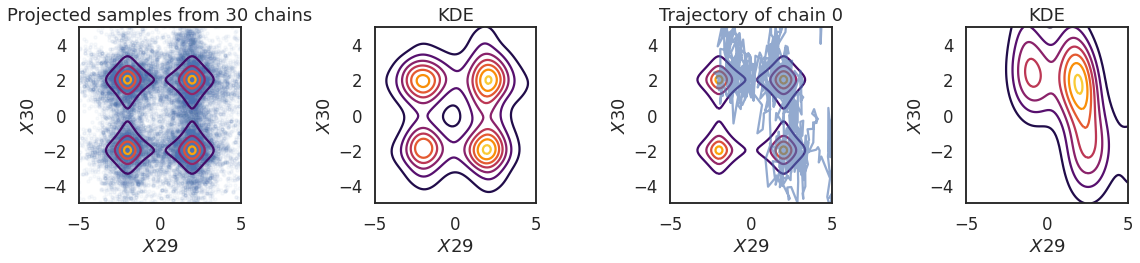

In [ ]:
plot_result(chains, moc)

In [ ]:
def AIS(start: torch.FloatTensor,
        target,
        proposal,
        *, 
        betas: Iterable,
        transition: Callable,
        verbose: bool = False) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
    """
    Annealed Importance Sampling

    Args:
        start - strating points of shape [n_samples x dim]
        target - target distribution instance with method "log_prob"
        betas - sequence of tempering coeffecients
        verbose - whether to fshow iterations' bar

    Returns:
        tensor of samples with shape [n_samples, dim], iportance weights
    """
    x = start.clone()
    x.requires_grad_(True)
    x.grad = None

    log_weight = torch.ones(x.shape[:-1])
    for beta_m, beta in zip(betas[:-1], betas[1:]):
        interm_target = copy.copy(target)
        interm_target.log_prob = lambda x: target.log_prob(x) * beta + proposal.log_prob(x) * (1. - beta)
        x = transition(x, interm_target).clone()
        log_weight += target.log_prob(x) * (beta - beta_m) + proposal.log_prob(x) * (1. - beta + beta_m)
    weight = torch.exp(log_weight)
    return x, weight


In [ ]:
betas = np.linspace(0, 1, 10, endpoint=True) ** .5
proposal_scale = 1.0
proposal = MNormal(torch.zeros(mog.dim), torch.eye(mog.dim) * proposal_scale ** 2)
start = proposal.sample((N_CHAINS * N_SAMPLES, mog.dim))
transition = lambda x, target: RWM(x, target, proposal=proposal, n_samples=5, burn_in=0, verbose=False)[0][-1]

samples, _ = AIS(start, mog, proposal, betas=betas, transition=transition, verbose=True)

In [ ]:
samples = samples.reshape(N_SAMPLES, N_CHAINS, -1)

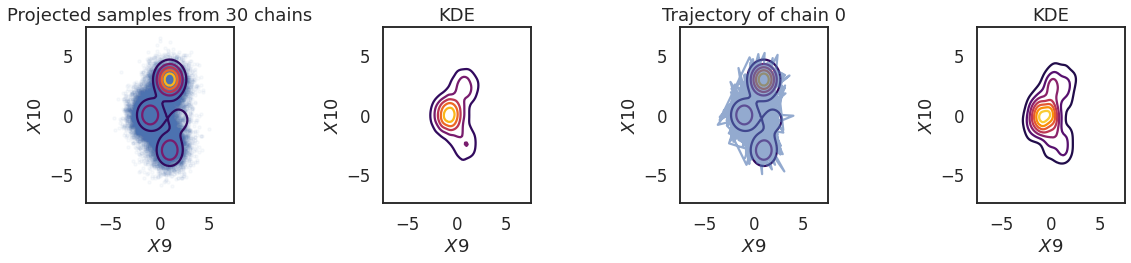

In [ ]:
plot_result(samples, mog)

In [ ]:
def TemperedTransitions(
    start: torch.FloatTensor,
    target,
    proposal,
    n_samples: int,
    burn_in: int,
    *,
    transition: Callable,
    betas: Iterable,
    verbose: bool = False,
) -> Tuple[torch.FloatTensor, List]:
    chains = []
    acceptance_rates = []

    betas = np.array(betas)
    betas_diff = torch.FloatTensor(betas[:-1] - betas[1:])

    x = start.clone()
    x.requires_grad_(True)
    x.grad = None

    energy_forward = torch.zeros(*x.shape[:-1], len(betas) - 1)
    energy_backward = torch.zeros(*x.shape[:-1], len(betas) - 1)
    interm_target = copy.copy(target)

    range_ = trange if verbose else range
    for step_id in range_(n_samples + burn_in):
        x_forward = x
        for i, beta in enumerate(betas[1:-1]):
            interm_target.log_prob = lambda x: target.log_prob(x) * beta + proposal.log_prob(x) * (1. - beta)
            x_forward = transition(x_forward, interm_target)
            energy_forward[:, i + 1] = -target.log_prob(x_forward)

        x_backward = x_forward
        for i, beta in enumerate(betas[::-1][1:-1]):
            interm_target.log_prob = lambda x: target.log_prob(x) * beta + proposal.log_prob(x) * (1. - beta)
            x_backward = transition(x_backward, interm_target)
            energy_backward[:, len(betas) - i - 3] = -target.log_prob(x_backward)

        F_forward = (betas_diff * energy_forward).sum(-1)
        F_backward = (betas_diff * energy_backward).sum(-1)
        accept_prob = torch.clamp((F_forward - F_backward).exp(), max=1)

        mask = torch.rand(accept_prob.shape) < accept_prob
        with torch.no_grad():
            x[mask, :] = x_backward[mask, :]
        acceptance_rates.append(mask.float().mean().item())
        if step_id >= burn_in:
          chains.append(x.detach().data.clone())

    chains = torch.stack(chains, 0)
    return chains, acceptance_rates

In [ ]:
betas = np.linspace(0, 1, 4, endpoint=True) ** .5
proposal_scale = 1.0
proposal = MNormal(torch.zeros(mog.dim), torch.eye(mog.dim) * proposal_scale ** 2)
transition = lambda x, target: MALA(x, target, n_samples=1, burn_in=0, step_size=0.1, verbose=False)[0][-1]

chains, _ = TemperedTransitions(start_mog, mog, proposal, N_SAMPLES, BURN_IN, betas=betas, transition=transition, verbose=True)

100%|██████████| 1100/1100 [00:24<00:00, 44.45it/s]


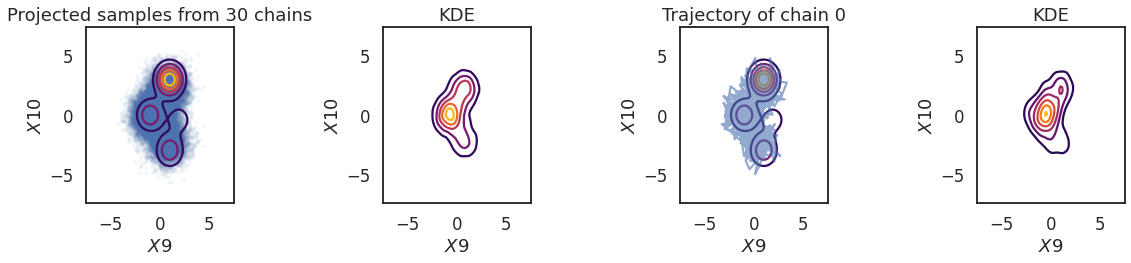

In [ ]:
plot_result(chains, mog)